In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from scipy import stats
import matplotlib as mpl
from datetime import datetime
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from networkx.utils import py_random_state
from itertools import combinations, groupby
import random, time, pickle, random, multiprocessing, matplotlib, copy, itertools

## Bulding the Network

In [2]:
def regular_clique(number_of_nodes, average_degree, clique_size):
    N, K, c = number_of_nodes, average_degree, clique_size
    if K % (c-1) != 0:
        raise Exception('This configuration is not possile')
    else:
        k = int(K/(c-1))
        m = int(N*k/c)
        nodes = [(u, _k) for u in range(N) for _k in range(k)]
        random.shuffle(nodes)
        cliques = [(u, _k) for u in range(m) for _k in range(c)]
        l = list(zip(cliques, nodes))
        my_list = [j[1][0] for j in l]
        node_collections = [my_list[i:i+c] for i in range(0, len(my_list), c)]
        g = nx.Graph()
        for col in node_collections:
            g.add_edges_from(itertools.combinations(col, 2))
        g.remove_edges_from(nx.selfloop_edges(g))
    return g

## Contact Tracing Process for finding $R_e$

In [3]:
def comp_g(g, compartment_name):
    '''
        returns nodes in compartment compartment_name
    '''
    return [node for node in g.nodes() if g.nodes()[node]['type'] == compartment_name]



def contact_tracing(g, alpha, p):
    '''
        returns number of nodes in different compartments S, I, QI, QS, R
        after runing the SIR+Q process
    ''' 
    G = copy.deepcopy(g)
    N = len(G)
    compartments = dict([(node,{'type':'S', 'time': 0, 'R0': 0}) for node in G.nodes()])
    nx.set_node_attributes(G, compartments)
    
    infection_seed = random.randint(0, N-1)
    G.nodes()[infection_seed]['type'] = 'I'
    G.nodes()[infection_seed]['time'] = 1

    new_seeds = {infection_seed} 
    time = 1
    while new_seeds and time < 4:
        #check if there is no infection left
        t = [quarantine_infection(seed, G, alpha, p, time) for seed in new_seeds]
        new_seeds = {item for sublist in t for item in sublist}
        time += 1
    
    S, I, R, QI, QS = comp_g(G, 'S'), comp_g(G, 'I'), comp_g(G, 'R'), comp_g(G, 'QI'), comp_g(G, 'QS')

        
    lst = [(G.nodes()[k]['time'], G.nodes()[k]['R0']) 
                      for k,v in sorted(dict(G.nodes()).items(), key = lambda item: item[1]['time'])
                      if G.nodes()[k]['type'] in ['QI', 'R']] 
                      #if G.nodes()[k]['type'] in ['R']]
    time_dependendt_R0 = dict()
    for k, group in groupby(lst, key=lambda ele: ele[0]):
        time_dependendt_R0[k]= np.mean([j for i,j in group])
    
    #times, R0_s = zip(*lst)
    times, R0_s = zip(*time_dependendt_R0.items())
    #R0_s = [G.nodes()[k]['R0'] for k,v in sorted(dict(G.nodes()).items(), key = lambda item: item[1]['time'])
     #                  if G.nodes()[k]['type'] not in ['QS', 'S']]
    #return [len(S)/N, len(I)/N, len(R)/N, len(QS)/N, len(QI)/N,  list(times), list(R0_s)]
    return list(R0_s)


def quarantine_infection(source, G, alpha, p, time):
    '''
        begins from new ifected nodes, yields new infected nodes
        while putting nodes in the right compartment
    '''
    G.nodes()[source]['time'] = time
    new_infected_nodes = []
    new_infection = 0
    for ne in G[source]:
        if G.nodes()[ne]['type'] == 'S':
            if random.random() <= alpha:
                G.nodes()[ne]['R0'] = 0
                G.nodes()[ne]['time'] = time+1
                if random.random()<= p:
                    G.nodes()[ne]['type'] = 'QI'
                    new_infection += 1
                    #new_infection += 1

                else:
                    G.nodes()[ne]['type'] = 'QS'
            else:
                if random.random() <= p:
                    G.nodes()[ne]['type'] = 'I'
                    new_infection += 1
                    new_infected_nodes.append(ne)
    G.nodes()[source]['type'] = 'R'
    G.nodes()[source]['R0'] = new_infection
    return new_infected_nodes

In [4]:
def same_size_maker(list_of_lists):
    M = max([len(item) for item in list_of_lists])
    all_lists = np.array([lst+[np.nan]*(M-len(lst)) for lst in list_of_lists])
    return np.nanmean(all_lists, axis = 0),  stats.sem(all_lists, axis=0, nan_policy='omit')

def repro_number(g, alpha, p, ens):
    rs = same_size_maker(Parallel(n_jobs = max(12, multiprocessing.cpu_count()))(delayed(contact_tracing)(g, alpha, p) for _ in range(ens)))[0]
    try:
        r = rs[2]
    except:
        r = rs[1]
    return r

In [ ]:
N = 4*10**5
alpha_range = np.linspace(0, 1, 10)
ens = 10**3
cs = [2,3,4]
p = 1.0

_i =0
cr = ['r', 'g', 'b']
lins = ['dashed', 'dashdot', 'dotted']

rs_list = []
for c in cs:
    G = regular_clique(N, 6, c)
    rs = [repro_number(G, alpha, p, ens) for alpha in alpha_range]
    rs_list.append(rs)
    plt.plot(alpha_range, rs, label = c, color = cr[_i],linestyle=lins[_i])
    _i += 1

    np.save(str(p)+'Ro'+str(N), rs_list)
plt.xlabel(r'$\alpha$', fontsize= '16')
plt.ylabel(r'$R_0$', fontsize= '16')
plt.axhline(y = 1, color = 'black', linestyle = '--')
plt.plot(alpha_range, [p*5*(1-alpha) for alpha in alpha_range], ':b', label = r'$(1-\alpha)pq$')
plt.legend()
plt.savefig(str(p)+'Ro'+str(N)+'.pdf')

## Loading from data

([<matplotlib.axis.XTick at 0x2b11d9a5d690>,
 [Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4, 0, '0.4'),
  Text(0.6, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0, 0, '1.0')])

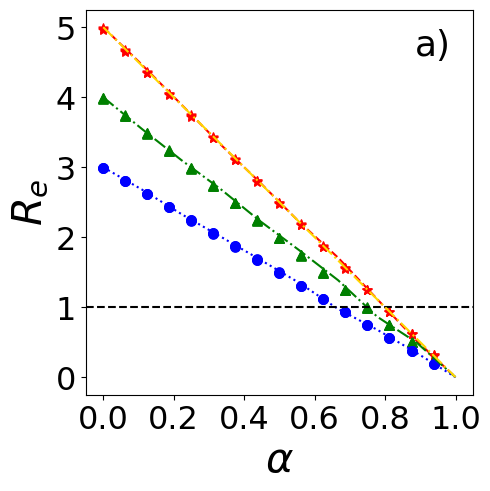

In [5]:
N = 5*10**5
alpha_range = np.linspace(0, 1, 10)
ens = 10**3
cs = [2,3,4]
p = 1.0
df = pd.read_csv('parsweep_noncc_4.csv')
labels = ['a)', 'b)', 'c)', 'd)']

_i =0
cr = ['r', 'g', 'b']
lins = ['dashed', 'dashdot', 'dotted']
markers = ['*', '^', 'o']

rs_list = np.load(str(p)+'Ro'+str(N)+'.npy')

fig, axs = plt.subplots(figsize=(5, 5))
data_p_1 = df[(df.p > .99)]
david_alpha = data_p_1['alpha'].to_numpy()

for c in cs:
    rs = rs_list[c-2]
    axs.plot(alpha_range, rs, color = cr[_i],linestyle=lins[_i], markersize = 10)
    axs.scatter(david_alpha[::25], data_p_1['lmax_value_'+str(c)].to_numpy()[::25], marker = markers[_i], label = c, color = cr[_i], s = 45)   
    _i += 1
plt.xlabel(r'$\alpha$', fontsize= '30')
plt.ylabel(r'$R_e$', fontsize= '30')
plt.axhline(y = 1, color = 'black', linestyle = '--')
alpha_range = np.linspace(0, 1, 25)
plt.plot(alpha_range, [p*5*(1-alpha) for alpha in alpha_range], linestyle='dashdot', color = 'gold', label = r'$(1-\alpha)pq$', markersize = 2)
#plt.legend(loc = 2, fontsize= 17)
axs.text(0.85, 0.95, labels[0], transform=axs.transAxes, fontsize=26,va='top')
axs.set_yticks(range(6))
plt.yticks(fontsize=23)
plt.xticks([0, 0.2, .4, .6, .8, 1], fontsize=23)

#axs.get_yaxis().set_visible(False)
#plt.savefig('4a'+'.pdf',bbox_inches='tight')

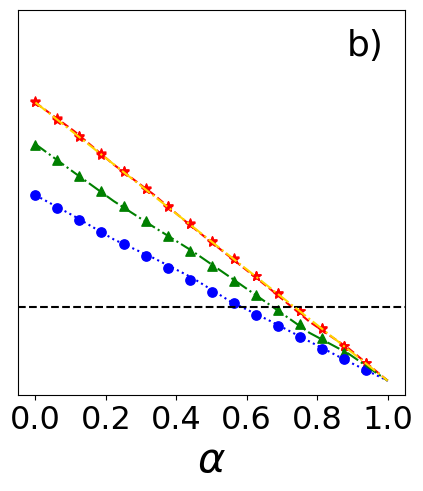

In [5]:
N = 5*10**5
alpha_range = np.linspace(0, 1, 10)
ens = 10**3
cs = [2,3,4]
p = 0.75

_i =0
cr = ['r', 'g', 'b']
lins = ['dashed', 'dashdot', 'dotted']

rs_list = np.load(str(p)+'Ro'+str(N)+'.npy')

fig, axs = plt.subplots(figsize=(5, 5))

for c in cs:
    rs = rs_list[c-2]
    axs.plot(alpha_range, rs,  color = cr[_i],linestyle=lins[_i], markersize = 10)
    if c ==2:
        data_p_1 = df[(df.p > .749) & (df.p < .756)]
        david_alpha = data_p_1['alpha'].to_numpy()
        axs.scatter(david_alpha[::25], data_p_1['lmax_value_'+str(c)].to_numpy()[::25], label = c,color = cr[_i], marker = markers[_i],  s = 45)   

    else:
        data_p_1 = df[(df.p > .749) & (df.p < .751)]
        david_alpha = data_p_1['alpha'].to_numpy()
        axs.scatter(david_alpha[::25], data_p_1['lmax_value_'+str(c)].to_numpy()[::25], label = c,color = cr[_i], marker = markers[_i],  s = 45)   
    _i += 1
plt.xlabel(r'$\alpha$', fontsize= '30')
#plt.ylabel(r'$R_0$', fontsize= '30')
plt.axhline(y = 1, color = 'black', linestyle = '--')
alpha_range = np.linspace(0, 1, 25)
plt.plot(alpha_range, [p*5*(1-alpha) for alpha in alpha_range], linestyle='dashdot', color = 'gold', label = r'$(1-\alpha)pq$', markersize = 2)
#plt.legend(loc = 2, fontsize= 17)
axs.text(0.85, 0.95, labels[1], transform=axs.transAxes, fontsize=26,va='top')
axs.set_yticks(range(6))
plt.xticks([0, 0.2, .4, .6, .8, 1], fontsize=23)
plt.yticks(fontsize=23)
axs.get_yaxis().set_visible(False)
plt.savefig('4b'+'.pdf',bbox_inches='tight')

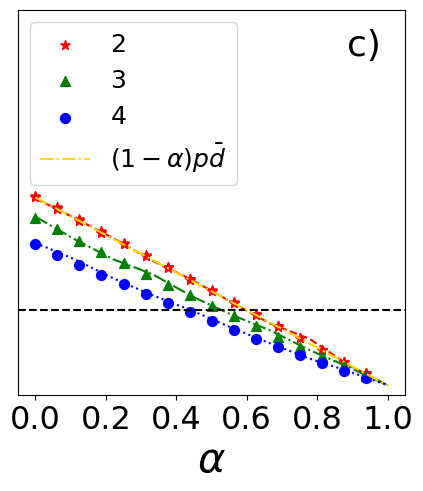

In [6]:
N = 5*10**5
alpha_range = np.linspace(0, 1, 10)
ens = 10**3
cs = [2,3,4]
p = 0.5

_i =0
cr = ['r', 'g', 'b']
lins = ['dashed', 'dashdot', 'dotted']

rs_list = np.load(str(p)+'Ro'+str(N)+'.npy')

fig, axs = plt.subplots( figsize=(5, 5))

for c in cs:
    rs = rs_list[c-2]
    axs.plot(alpha_range, rs,  color = cr[_i],linestyle=lins[_i], markersize = 10)
    if c ==2:
        data_p_1 = df[(df.p > .499) & (df.p < .506)]
        david_alpha = data_p_1['alpha'].to_numpy()
        axs.scatter(david_alpha[::25], data_p_1['lmax_value_'+str(c)].to_numpy()[::25], label = c,color = cr[_i],  marker = markers[_i], s = 50)   

    else:
        data_p_1 = df[(df.p > .499) & (df.p < .5025)]
        david_alpha = data_p_1['alpha'].to_numpy()
        axs.scatter(david_alpha[::25], data_p_1['lmax_value_'+str(c)].to_numpy()[::25], label = c, color = cr[_i], marker = markers[_i],  s = 50)   
    _i += 1
plt.xlabel(r'$\alpha$', fontsize= '30')
#plt.ylabel(r'$R_0$', fontsize= '30')
plt.axhline(y = 1, color = 'black', linestyle = '--')
alpha_range = np.linspace(0, 1, 25)
plt.plot(alpha_range, [p*5*(1-alpha) for alpha in alpha_range], linestyle='dashdot', color = 'gold', label = r'$(1-\alpha)p\bar{d}$', markersize = 2)
plt.legend(loc = 2, fontsize= 18)
axs.text(0.85, 0.95, labels[2], transform=axs.transAxes, fontsize=26,va='top')
axs.set_yticks(range(6))
plt.xticks(fontsize=23)
plt.xticks([0, 0.2, .4, .6, .8, 1], fontsize=23)

axs.get_yaxis().set_visible(False)
plt.savefig('4c'+'.pdf',bbox_inches='tight')
